In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
train = pd.read_csv("/content/drive/MyDrive/7313Project/train_reduced.csv")
testn = pd.read_csv("/content/drive/MyDrive/7313Project/test_reduced.csv")
target = pd.read_csv("/content/drive/MyDrive/7313Project/target.csv")

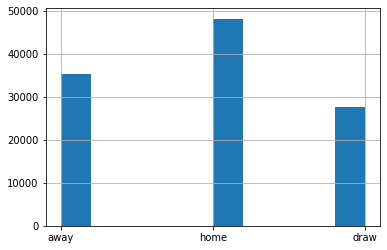

In [ ]:
target['target'].hist()

In [ ]:
train.drop(train.iloc[:, [0,1]], axis=1, inplace=True)
test.drop(test.iloc[:, [0,1]], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:
train['is_cup'] = labelencoder.fit_transform(train['is_cup'])
test['is_cup'] = labelencoder.fit_transform(test['is_cup'])
target['target'].replace({"home": 0, "draw": 1, "away":2}, inplace=True)
train.drop(train.filter(regex='recorded_matches').columns, axis=1, inplace = True)
test.drop(test.filter(regex='recorded_matches').columns, axis=1, inplace = True)
train_x = train.copy()
train_y = target['target'].copy()
train_x.fillna(train_x.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
#fit scaler on training data
norm = StandardScaler().fit(train_x)
#transform training data
xtrain_norm = norm.transform(train_x)
#transform testing data
test_norm = norm.transform(test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


cv_acc = cross_val_score(estimator=LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000),
                         X=xtrain_norm,
                         y=train_y,
                         cv=10,
                         n_jobs=-1)

print('Kfold Accuracy: %.2f%%' % (np.mean(cv_acc)*100))

Kfold Accuracy: 46.06%


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

lg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=10000)
cc = CalibratedClassifierCV(lg, cv=10)
cc.fit(xtrain_norm, train_y)
prediction_1 = cc.predict_proba(test_norm)
prediction_1

array([[0.41770758, 0.31009521, 0.2721972 ],
       [0.33941906, 0.29585446, 0.36472648],
       [0.40634521, 0.28854204, 0.30511276],
       ...,
       [0.0920527 , 0.25089735, 0.65704994],
       [0.5427168 , 0.28666719, 0.17061601],
       [0.37048226, 0.26710045, 0.36241728]])

In [ ]:
y_pred = cc.predict(xtrain_norm)
train_acc = np.mean(y_pred == train_y)*100
train_acc

49.567325893742456

In [ ]:
from mlxtend.evaluate import confusion_matrix
confmat = confusion_matrix(train_y, y_pred)

print(confmat)

[[38475   272  9366]
 [19164   295  8192]
 [18729   226 16219]]


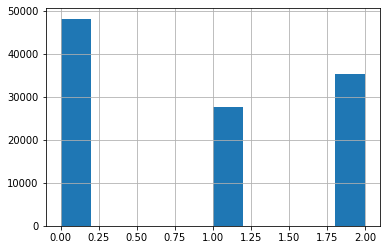

In [ ]:
target['target'].hist()

In [ ]:
submission = pd.concat([pd.DataFrame(testn['id']), pd.DataFrame(prediction_1, columns=['home', 'draw', 'away'])[['home', 'draw', 'away']]], axis=1)
submission.to_csv('/content/drive/MyDrive/7313Project/submission_logistic.csv', index=False)